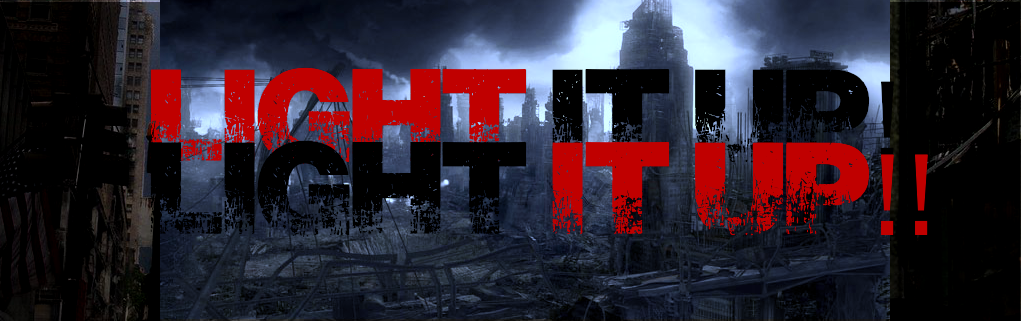

In [17]:
import sys
import time
import pyglet
import pygame


import numpy as np


import IPython
from IPython.display import Audio
from IPython.core.display import HTML
from IPython.display import clear_output
from IPython.display import display, Markdown

import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.ticker import MultipleLocator


sound_disc1 = "Images/PostApocSound2.mp3"


%matplotlib inline
# %config InlineBackend.figure_formats=set(['svg'])

def PrintText (text, delay):
    for l in text: 
        sys.stdout.write(l)
        sys.stdout.flush()
        time.sleep(delay)
        pygame.mixer.music.play()

pygame.init()

pygame.mixer.music.load('Images/typewriterkey.wav')

from IPython.display import Image
Image("Images/LightItUp.png", width=1500,
    height=100)

In [4]:
text =  "Hey, you\n"
text2 = '...\n'
text3 = 'Nice to see you here. I would like to tell you my story\n'
text4 = 'First, watch the video I made and find out the secrets of our time.\n'

text_dic = {text:0.2, text2:0.5, text3:0.05, text4:0.05}

for text, delay in text_dic.items():
    PrintText(text,delay)

time.sleep(1)
clear_output(wait=False)
key = True

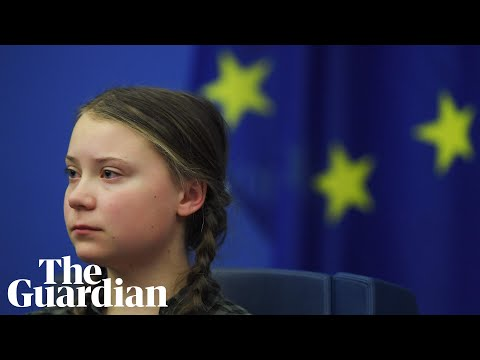

In [7]:
from IPython.display import YouTubeVideo

YouTubeVideo('FWsM9-_zrKo', width=800, height=500)

In [8]:
text2 = 'I am going to try to turn on all the lights in District 1\n'
text3 = 'I hope you can help me. I will explain how.\n'

text_dic = {text2:0.1, text3:0.1}

for text, delay in text_dic.items():
    PrintText(text,delay)

time.sleep(1)
clear_output(wait=False)

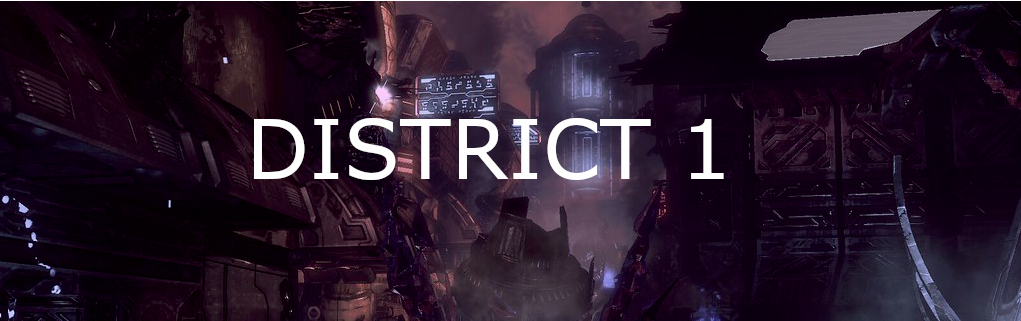

In [9]:
Image("Images/District 1_edit2.jpg", width=1500,
    height=100)

In [10]:
Audio(sound_disc1, autoplay=key)

### In District 1, there is a windmill park with 4 windmills.
\
Madica found that the wind turbines convert wind into electrical energy.\
The current display of the windmills does not produce energy enough to light up District1.\
Putting one windmill in front of each other is not going to generate energy enough for the whole district 1.\
Behind a turbine, the speed of wind is reduced about 1/3. This phenomenon is called the wake.\
\
Type the position you want to display each windmill and check out if you reached an optimal energy level.

In [11]:
turbines = pd.read_csv('T1.csv')

power_prod=turbines.iloc[:,1:]
power_prod.drop(columns=['Theoretical_Power_Curve (KWh)'], inplace=True)
power_prod=power_prod.round(1)

def round_wind_direction(x):
    list_of_directions=[15+i*30 for i in range(11)]
    N=sum([x>i for i in list_of_directions])
    return N*30

power_prod['mean_Direction']=power_prod['Wind Direction (°)'].apply(round_wind_direction)
power_prod['Round_speed']=power_prod['Wind Speed (m/s)'].apply(lambda x: np.round(2*x)/2.0)

def energy_production(wind,direction):
    temp=power_prod[(power_prod['Round_speed']==wind) & (power_prod['mean_Direction']==direction)]['LV ActivePower (kW)']
    if temp.shape[0]==0:
        return 0
    else:
        return temp.mean()
    
def direction_ranking(dataset,direction):
    dir_vector=[-np.sin(direction),-np.cos(direction)]
    if direction==0:
        dataset['rank']=5-dataset['Y']
    if direction==90:
        dataset['rank']=5-dataset['X']
    if direction==180:
        dataset['rank']=dataset['X']
    if direction==270:
        dataset['rank']=dataset['Y']
    return dataset.sort_values(by='rank')   

def wake_coef(x):
    return 1-1/((1+0.08*x)**2)

def wind_coefficients(dataset, direction):
    wind_coef=np.ones(dataset.shape[0])
    if direction==0:
        for t in dataset.itertuples():
            for u in dataset.itertuples():
                if (t.X==u.X) & (t.rank<u.rank):
                    wind_coef[u.Index]*=wake_coef(abs(t.Y-u.Y))
    if direction==90:
        for t in dataset.itertuples():
            for u in dataset.itertuples():
                if (t.Y==u.Y) & (t.rank<u.rank):
                    wind_coef[u.Index]*=wake_coef(abs(t.X-u.X))
    if direction==180:
        for t in dataset.itertuples():
            for u in dataset.itertuples():
                if (t.X==u.X) & (t.rank>u.rank):
                    wind_coef[u.Index]*=wake_coef(abs(t.Y-u.Y))
    if direction==270:
        for t in dataset.itertuples():
            for u in dataset.itertuples():
                if (t.Y==u.Y) & (t.rank>u.rank):
                    wind_coef[u.Index]*=wake_coef(abs(t.X-u.X))
    return wind_coef            

def wind_grid_energy_production(dataset, wind, direction):
    total_energy=0
    direction_ranking(dataset,direction)
    wind_coef=wind_coefficients(dataset,direction)
    total_energy=sum([energy_production(i*wind,direction) for i in wind_coef])
    return total_energy

# Grid coordinates:
x = ['1', '2', '3', '4']
y = ['A', 'B', 'C', 'D']

coord_grid = {}
for i in range(4): # Iterate over y coordinates
    yi = 7/8 - 0.25*i
    for j in range(4): # Iterate over x coordinates
        xi = 1/8 + 0.25*j
        coord_grid[y[i]+x[j]] = [xi, yi]

temp_dataset_max=pd.DataFrame([coord_grid['A1'], coord_grid['A2'], coord_grid['A3'], coord_grid['A4']], columns=['X','Y'])
maxwpower = wind_grid_energy_production(temp_dataset_max,5.0,0)

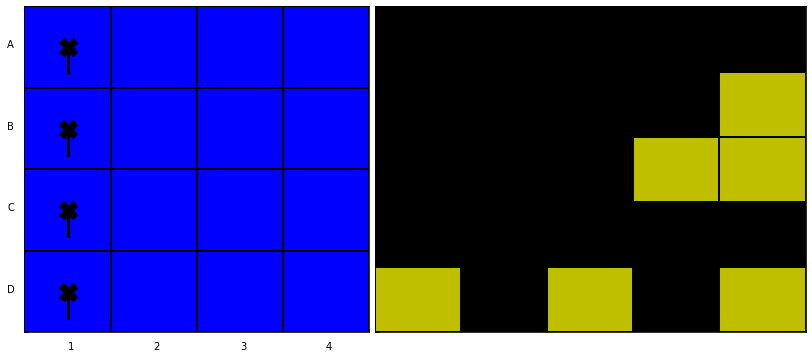

In [12]:
def gridout(incoord=''):
# incoord = input('Give coordinates:')
#print(coord_grid[incoord])
    temp_dataset=pd.DataFrame([coord_grid[elem] for elem in incoord.split()], columns=['X','Y'])
    perc = wind_grid_energy_production(temp_dataset,5.0,0) / maxwpower

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6), gridspec_kw={'width_ratios': [1, 1.25]})
    fig.subplots_adjust(wspace=0.015)


    ax1.grid(color='k', linewidth=2)
    for elem in incoord.split():
        ax1.plot(coord_grid[elem][0], coord_grid[elem][1], 'kX', markersize=18)
        ax1.plot(coord_grid[elem][0]*np.ones(100), np.linspace(coord_grid[elem][1]-0.08, coord_grid[elem][1], 100), color='k', linewidth=3)

    ax1.tick_params(axis="y",direction="in")
    ax1.tick_params(axis="x",direction="in")

    ax1.yaxis.set_major_formatter(plt.NullFormatter())
    ax1.xaxis.set_major_formatter(plt.NullFormatter())

    ax1.set_xticks(np.linspace(0., 1., 5))
    ax1.set_yticks(np.linspace(0., 1., 5))

    for i in range(4):
        ax1.text(1/8 + 0.25*i, -0.05, x[i])
        ax1.text(-0.05, 7/8 - 0.25*i, y[i])

    ax1.set_facecolor('blue')
    
    ax2.grid(color='k', linewidth=2)
    ax2.tick_params(axis="y",direction="in")
    ax2.tick_params(axis="x",direction="in")
    ax2.yaxis.set_major_formatter(plt.NullFormatter())
    ax2.xaxis.set_major_formatter(plt.NullFormatter())

    ax2.set_facecolor('black')
    points = np.linspace(0., 0.8, 5)

    points_coord = []
    for i in points:
        for j in points:
            points_coord.append('%f %f' %(i, j))
        
    points_coord = np.asarray(points_coord, dtype=str)

    #perc = 0.25
    numr = int(perc*25)
    #x0, y0 = np.random.choice(points, size=(numr, 2))
    rand_points = np.random.choice(points_coord, size=numr, replace=None)
    rand_points = [np.asarray(elem.split()).astype(np.float) for elem in rand_points]

    for r in range(numr):
        rect = Rectangle(rand_points[r], 0.2, 0.2, color='y')
        ax2.add_patch(rect)

    plt.show()
    return perc 
perc = gridout('A1 B1 C1 D1')

In [15]:
incoord = input('Give coordinates: ')
perc = gridout(incoord)

time.sleep(20)
clear_output(wait=False)

In [16]:
pygame.init()
pygame.mixer.music.load('Images/typewriterkey.wav')
if (perc == 1):
    text  =  "Congratulations! You lit up District 1!!!\n"
    text1 = "Now Humanity has hope again!"

    text_dic = {text:0.1, text1:0.1}

    for text, delay in text_dic.items():
        PrintText(text,delay)
        
else:
    text  =  "Nice try! Now part of District 1 has light!\n"
    text1 = "However... Dark corners invite... enemies...\n"

    text_dic = {text:0.1, text1:0.1, text2:0.1}

    for text, delay in text_dic.items():
        PrintText(text,delay)
        
time.sleep(5)
clear_output(wait=False)
pygame.quit()

error: mixer not initialized